# Mesure de statistique de $\hat{n}(t)$ par accumulation d'histogrammes
- Générales
    - Facteur $\sqrt{2/Zh}$
- Mesure de $V(t)$
    - Simulée par numpy.random $\checkmark$
- Calcul de $p(t)$ et $q(t)$
    - Convolution directe
        - using numpy.convole $\checkmark$
        - hard code python
        - hard code C
    - Convolution fftconvole
        - Origine des erreurs de bord
        - Corrections des erreurs de bord
        - using scipy.signal.fftconvolve
        - hard code python
        - hard code C
- Histogrramme 1D
    - Adapter code JO aux floats
- Histogrramme 2D
    - Adapter code JO aux floats
- Moments et cumulants
- Étude de l'efficacité de calcul



## Variables et unitées
- Variables mathématiques
    - Tension : $V(t)$
    - La fonction de transfert du système : $\beta(t)$ en $\mathrm{[V]/[V]}$
    - Les quadratures en temps : $q(t)~;~p(t) $
    - Les moments de P et Q : 
    - Les espérances de $\hat{n}$ :
- Variables informatiques
    - Tension mesurée  
        - V_i en $\mathrm[V]$
        - Nb points dans V_i : N_Vi
    - Les quadratures en temps mesurée 
        - P_i , Q_i en $\mathrm[V] / \mathrm[\sqrt{Zh}]$
        - Nb de points : N_QP
    - Noyaux des transformées de Reulet représentation en temps
        - NoyauP, NoyauQ
        - Nb points à droite : N_Noyaux
    - Noyaux des transformées de Reulet représentation en fréquence
        - NoyauP, NoyauQ
        - Nb points = N_QP
    - Les objets d'accumulation d'histogramme : $h_{P_i}~\&h_{Q_i}$
    - Les moments de P et Q : 
    - Les espérances de $\hat{n}$ :

## All the import stuff

In [1]:
# PATH management stuff
import sys
sys.path.insert(0, 'C:/Users/simon/Desktop/CODES/Time_quadratures-OTF')
sys.path.insert(0, 'C:\Projets\TimeQuad\Time_quadratures-OTF')
import add_mingw_to_PATH

# plot stuff
from matplotlib.pyplot import  plot, xlabel, ylabel, axis, hist, figure, axis, subplots, xlim, ylim
from mpl_toolkits.mplot3d import axes3d, Axes3D 
# timeit funcitonnalities stuff
from IPython import get_ipython
ipython = get_ipython()
# NUMPY
    # np utilities stuff
from numpy import array, meshgrid, arange, zeros, array_equal, around
    # np convolution stuff
from numpy import convolve
    # np FFT stuff
from numpy.fft import fft, fftfreq
    # np random stuff
from numpy.random import normal, randint
    # numpy type stuff
from numpy import  int16
# SCIPY 
from scipy.signal import fftconvolve

# CUSTOM PY MODULE stuff
from Python_Module import*
# CPP Time_Quad stuff
from time_quadratures import*

ImportError: No module named add_mingw_to_PATH

## Options d'exécution

In [2]:
# Figures optionnelles
OptionalPlots = set([
    #'Beta_t', 
    #'HistoV_i',
    #'NoyauxDeT',
    #'NoyauxDeT_CPP'
    #'PetQ_direct',
    'PetQ_FFT_Py',
    'PetQ_Scipy',
    'PetQ_CPP'
])

# Sections optionnelles
OptionalSec = set([
    #'CompareKernel',
])

# Exécution de l'algorithme (options):
NoiseType = set([
    'GaussianNoise',
    # 'GuzzikOutput',
])
ConvolutionType = set([
    #'Directe',
    'FFT_Scipy',
    'FFT_Py',
    #'Directe_CPP',
    'FFT_CPP',
    # FFT_Parallel_1,
    # FFT_Parallel_2,
])
HitogrameType = set([
    # 1D_py,
    # 2D_py,
    # 
])

# Générales

Gestion des préfacteurs $\sqrt{\frac{2}{Zh}}$..?

 ### $\beta(t)$ idéalle
    - La fonction $\beta(t)$ combiné du Guzik, des amplis et des fils est modélisée par un filtre passante bande idéal entre $0.5~\mathrm[GHz]$ et $10~\mathrm[GHz]$. Ça largeur à mis hateurs temporelles est $\approx 0.1~\mathrm{[ns]}$.
    - Le noyaux des convolutions de P et Q construit pour être beaucoup plus large que $\beta(t)$

In [3]:
if 'Beta_t' in OptionalPlots:
    Beta_t(Df  = 0.0005e9,N = 2**16,Fmin=  0.5e9)

## Instantification de Time_Quad

In [4]:
L_kernel = 1<<8;
L_data= 1<<20;
L_FFT = 1<<10;

dt = 0.03125; # [ns]; # Default value
Convolution_type = 'fft'; # Default value

X = Time_Quad_double_int16_t( L_kernel, L_data, L_FFT);

### Numpy instance through buffer protocol
 - copy = False :
     The numpy array instane uses the C++ allocated memory 
 - Memory is only deallocated when X is detroyed by python

In [5]:
# Numpy instance of arrays
data = array(X.data, copy = False);

kernel_p = array(X.kernel_p, copy = False);
kernel_q = array(X.kernel_q, copy = False);

p_full = array(X.p_full, copy = False);
p_valid = array(X.p_valid, copy = False);

q_full = array(X.q_full, copy = False);
q_valid = array(X.q_valid, copy = False);

# Mesures de $V(t)$

$\expval{V_i} =0 ~;~~ \sigma = 2^{12}~;~~\mathrm{Max(int16)} = 2^{15}-1=32767~;~~\mathrm{Min(int16)} = -2^{15}-32768$

In [6]:
if 'GaussianNoise' in NoiseType :
    mu=0
    sigma=2**12
    V_i = normal(mu,sigma,L_data); V_i = int16(V_i) 
    
    if 'HistoV_i' in OptionalPlots:
        figure()
        count, bins, ignored = hist(V_i,100, density=True); xlabel('[V]')

### Coying the data to the C++ array

In [7]:
data[:] = V_i;

# Calcul de $P_i$ et $Q_i$ par convolution

##  Noyaux de convolutions :
 - Les noyaux ont un nombre paires de point et de sont jamais évalués à $t=0$.
 - $p(t)$ et q(t) sont définie comme des intégrales en valeure principale. 
$$p(t) = \frac{s_+(t) + s_-(t)}{2}$$
$$q(t) = \frac{s_+(t) - s_-(t)}{2}$$
$$s_{\pm}(t) = \sqrt{\frac{2}{Zh}} \int_{\pm} \frac{v(t-t')}{\sqrt{|t'|}}$$
Pour approcher numériquement une intégrale en valeur principale les noyaux NoyauP($t=0$) et NoyauQ($t=0$) $\equiv 0$
- Ceci est atteint en construisant  NoyauP($t$) et NoyauQ($t$) comme des vecteurs à nombre de points paire centrée autour de $t=0$ ainsi NoyauP($t=0$) et NoyauQ($t=0$) ne sont pas évaluer dans le vecteurs (effectivement nulle).
 - Conceptuellement cela revient à dire que les représentations discrête de $p(t)$ et $q(t)$ seront décaler de $\Delta t/2$ vers la droite par rapport à la représentation discrète de $v(t)$.

### Comparer les kernels

if 'CompareKernel' in OptionalSec :
    T_kernels = Abscisse_Kernel_time(L_kernel, dt)
    # De PY MODULE :
    (NoyauP,NoyauQ) = Kernels_time(L_kernel, dt)  # [ns^-1/2]
    # De Time_Quad :
    #figure()
    #plot(T_kernels,NoyauP); plot(T_kernels,NoyauQ); xlabel('[ps]');ylabel('[ns-1/2]')
    #figure()
    #plot(T_kernels,kernel_p); plot(T_kernels,kernel_q);xlabel('[ps]');ylabel('[ns-1/2]')
    #figure()
    #plot(T_kernels,kernel_p-NoyauP);plot(T_kernels,kernel_q-NoyauQ);xlabel('[ps]');ylabel('[ns-1/2]')
    
    print("k_p(t) are equal =",array_equal(kernel_p,NoyauP))
    print("k_q(t) are equal =",array_equal(kernel_q,NoyauQ))
    

    #De PY MODULE :
        #F_Noyaux = Abscisse_Kernel_freq(L_kernel,dt)
    #Zero padding the Kernel
    k_p = zeros(L_FFT); k_p[0:L_kernel] = NoyauP;
    k_q = zeros(L_FFT); k_q[0:L_kernel] = NoyauQ;
    PY_FFT_k_p = fft(k_p)[:L_FFT/2+1];
    PY_FFT_k_q = fft(k_q)[:L_FFT/2+1];
   
    # De Time_Quad :
    #X.execute();
    X.execute_kernel();
    
    #figure()
    #fig, axs = subplots(1,2,figsize=(20,10),sharey='row') #xlabel([GHz])
    #axs[0].plot(PY_FFT_k_p.real);axs[0].plot(PY_FFT_k_p.imag)
    #axs[1].plot(FFT_kernel_p.real);axs[1].plot(FFT_kernel_p.imag);
    #axs[1,0].plot(fft(NoyauQ).imag)
    #axs[1,1].plot(FFT_kernel_q.imag)
    
    # a d decimales près
    d = 10
    print("k_p(f) are equal =",array_equal( around(FFT_kernel_p,d),around(PY_FFT_k_p,d) ) )
    print("k_q(f) are equal =",array_equal( around(FFT_kernel_q,d),around(PY_FFT_k_q,d) ) )

## Convolution directe

### Comparaison entre numpy.convolve et Time_Quad

if 'Directe' in ConvolutionType :
    # En python
    P_i = convolve(kernel_p,data,mode='full')
    Q_i = convolve(kernel_q,data,mode='full')
    
    # En c++
    X.Convolution_type = 'direct';
    X.execute();
    
    if 'PetQ' in OptionalPlots :
        fig, axs = subplots(3,2,figsize=(10,10))
        axs[0,0].plot(P_i,'+');axs[0,1].plot(Q_i);
        axs[1,0].plot(p_full,'+');axs[1,1].plot(q_full);
        axs[2,0].plot((p_full-P_i),'+');axs[2,1].plot((q_full-Q_i));
    # garbage
    del data, kernel_p, kernel_q, p_full, q_full, X

## Convolution FFT

### Avec scipy.signal.ffconvolve

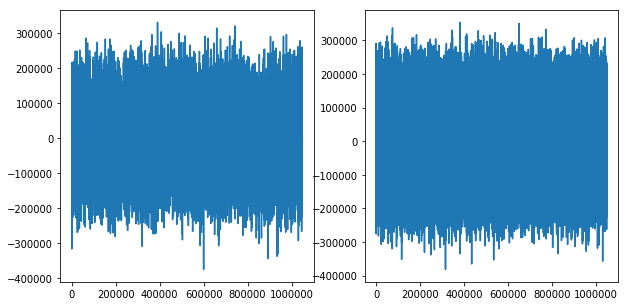

In [8]:
if 'FFT_Scipy' in ConvolutionType :
    # Construct Noyau
    (NoyauP,NoyauQ) = Kernels_time(L_kernel, dt)   # [ns^-1/2]
    P_i_scipy = fftconvolve(NoyauP,V_i,mode='full') # shape 9001
    Q_i_scipy = fftconvolve(NoyauQ,V_i,mode='full')
    # plot et Histrogramme de P et Q (fait par Python)
    if 'PetQ_Scipy' in OptionalPlots :
        fig, axs = subplots(1,2,figsize=(10,5))
        axs[0].plot(P_i_scipy);axs[1].plot(Q_i_scipy);
       #axs[1,0].hist(P_i_scipy,100);axs[1,1].hist(Q_i_scipy,100);

### En prenant la transformée de Fourier inverse
$$ P(t) = \mathcal{F}^{-1}\Bigg\{\frac{1}{\sqrt{|f|}} \mathcal{F}\Big\{v(t)\Big\}\Bigg\}$$

$$ Q(t) = \mathcal{F}^{-1}\Bigg\{-i\frac{\mathrm{sgn}(f)}{\sqrt{|f|}} \mathcal{F}\Big\{v(t)\Big\}\Bigg\}$$

 - J'écrit l'lagorithme en me basant sur https://www.dspguide.com/ch18/2.htm
 - Voir aussi http://www.bitweenie.com/listings/fft-zero-padding/
 - Le résultat d'une FFT convolution est indentique au résultat d'une convolution (à la propagation d'erreur près).
 - Seule la section "valid" de la convolution m'intéresse ou le kernel et le signal s'overlap completement. Elle a longueur max(M,N) - min(M,N) + 1. Pour un signal v(t) en $10^9$ points et un Kernel de $10^3$ points $p(t)$ et $q(t)$ sont donc valident sur $10^9-10^3+1$ points.
 - Les FFTs sont plus efficaces pour des vecteurs de longueur en puissance de 2. La puissance de 2 la plus près de 10^9 est 2^30 = 1073741824 le signal pourrait donc être traité en une seulle FFT, mais celle-ci serait beaucoup trop longent
 - Une meilleure alternative est choisir des longueurs de FFT plus raisonnable en segmentant le vecteur V_i et segment v_i de longeur N_vi et en respectant la règle N_vi + N_kernel -1 = 2^n. Ceci empêche la convolution d'être circulaire.
 - Les signaux p(t) et q(t) sont alors récupérés en prenant la somme sur les transformées inverses (voir : https://www.dspguide.com/ch18/2.htm)
 - Pour l'instant N_kernel = 10^3; 2^n= 2^11 = 2048 et donc N_vi = 1049 

### Pré-calcul de NoyauP et NoyauQ dans l'espace des fréquences
    - La forme de NoyauP et NoyauQ est analytique pas besoin de fair une FFT.
    - Ils ont déjà été calculé plus haut
 

In [9]:
if 'FFT_Py' in ConvolutionType :    
    # Calcul parrallèlisable de p_i et q_i
    (P_i, Q_i) = FFTConv(V_i, L_kernel, L_FFT, dt)

if 'FFT_CPP' in ConvolutionType:
    a=1;

In [10]:
# En c++
X.Convolution_type = 'fft';

In [11]:
X.execute();

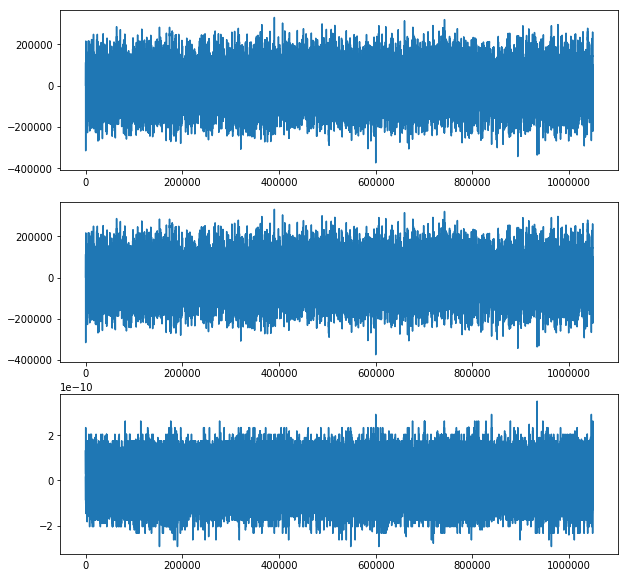

In [12]:
if 'PetQ_CPP' in OptionalPlots :
    fig, axs = subplots(3,1,figsize=(10,10))
    SLICE = slice( None, None, None );
    axs[0].plot(P_i_scipy[SLICE])#;axs[0,1].plot(Q_i_scipy);
    axs[1].plot(p_full[SLICE])#;axs[1,1].plot(q_full);
    axs[2].plot(P_i_scipy[SLICE]-p_full[SLICE])
    #axs[1,0].hist(P_i_scipy,100);axs[1,1].hist(Q_i_scipy,100);

# plot et Histrogramme de P et Q (fait par Python)
if 'PetQ' in OptionalPlots :
    fig, axs = subplots(2,2,figsize=(10,10))
    axs[0,0].plot(P_i);axs[0,1].plot(Q_i);
    axs[1,0].hist(P_i,100);axs[1,1].hist(Q_i,100);

## Différence entre scipy.fftconvolve et FFTConv

figure
plot(P_i-P_i_scipy); 
plot(Q_i-Q_i_scipy);

P_i_scipy.size

# Histogramme 1D

 Méthodes d'accumulation d'histogramme 1D et 2D en python et en C écrit par JO
 Contient aussi des méthodes de calcul de moment et de cumulants écrit en python et en C 


# Méthodes de JO
#import sys, os
#sys.path.append('C:/Users/simon/Desktop/TimeDomain_Guzik/Code/Histograms-OTF/')
#from histograms_otf import hist1dNbits, hist2dNbits
# Autres packages

## Accumulation des histogrammes de P et Q

Ne peut pas ré-utiliser le code d'accumulation d'histogramme de JO, car mes histogrammes sont nécessairement des float à cause de


